In [143]:
import pandas as pd
import numpy as np
import scipy as sp
import random
import scipy.stats
import math
import statistics
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller

In [239]:
df = pd.read_csv(r"weatherAUS.csv")
df = df.drop(np.arange(3040,len(df)))
df = df[["Date","MaxTemp"]]
df = df.dropna()
df = df.reset_index()
#df.insert(0,"index",np.arange(len(df)))
#df.set_index("index")

df.head()

,index,Date,MaxTemp
0,0,2008-12-01,22.9
1,1,2008-12-02,25.1
2,2,2008-12-03,25.7
3,3,2008-12-04,28.0
4,4,2008-12-05,32.3


In [211]:
t = df["index"]
temp = df["MaxTemp"]

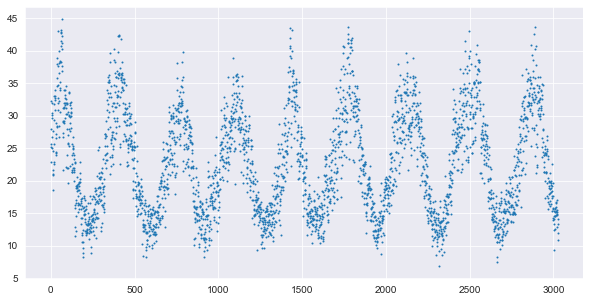

In [233]:
plt.figure(figsize = (10,5))
plt.scatter(t,temp,s=1)
#plt.xlabel("PKB na osobę")
#plt.ylabel("poziom szczęścia")
#plt.title("Wykres zależności poziomu szczęścia od PKB na osobę")

#plt.savefig('plot1.pdf', format='pdf')

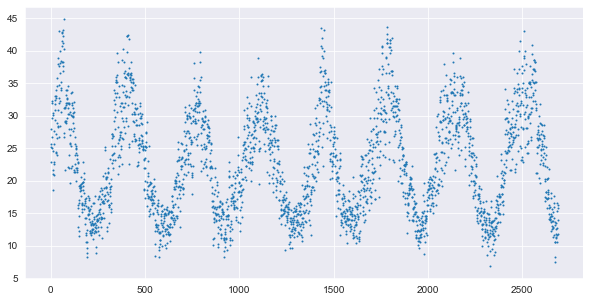

In [234]:
train = df[:2680]
test = df.drop(train.index)
plt.figure(figsize = (10,5))
plt.scatter(train["index"],train["MaxTemp"],s=1)

train_t = train["index"]
train_temp = train["MaxTemp"]

In [235]:
#dekompozycja liniowości
a,b = np.linalg.lstsq(np.vstack([train_t, np.ones(len(train_t))]).T, train_temp, rcond=None)[0]

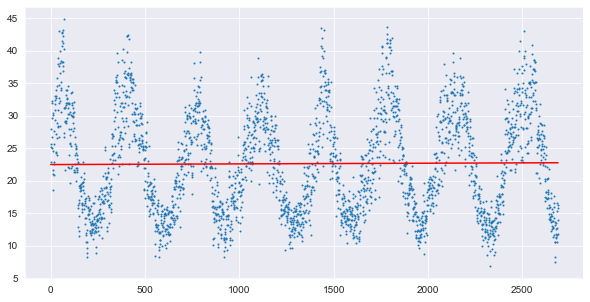

In [236]:
plt.figure(figsize = (10,5))
plt.scatter(train_t,train_temp,s=1)
plt.plot(train_t,a*train_t+b,"r")

In [237]:
train["index"][282:284]

282    282
283    284
Name: index, dtype: int64

In [238]:
train_temp_2 = []
for i in range(len(train)):
    train_temp_2.append(train_temp[i] - a*train_t[i] - b)

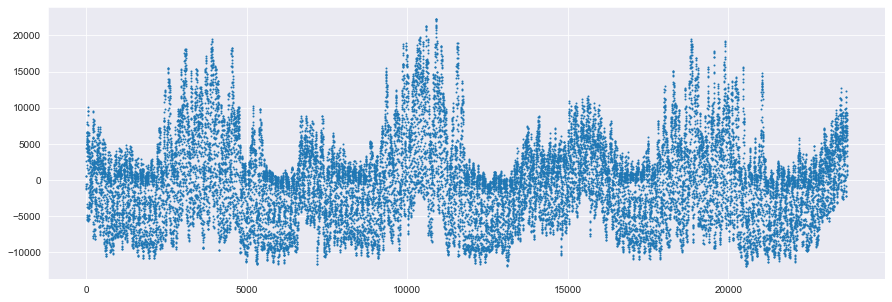

In [158]:
plt.figure(figsize = (15,5))
plt.scatter(train_t,train_energy_2,s=1)

In [159]:
def func(t, c, d, e):
    return c*np.abs(np.sin(d*t)-np.cos(2*d*t)) - e

Q = np.quantile(Xt2, 0.9)
p0 = [Q,1/(6000/1/(2*np.pi)),np.random.random()]
c_est, d_est, e_est = sp.optimize.curve_fit(func, xdata = date, ydata = Xt2, p0=p0, bounds = ((Q,0,0),(50000,np.inf,1)))[0]

ValueError: operands could not be broadcast together with shapes (3040,) (32896,) 

ValueError: x and y must be the same size

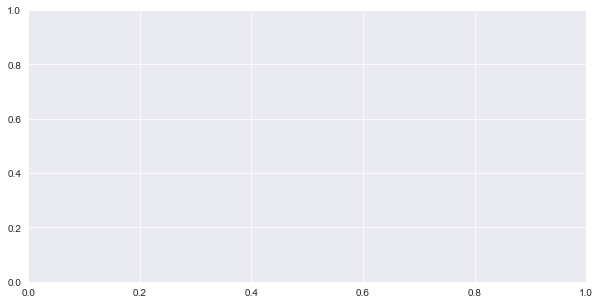

In [160]:
plt.figure(figsize = (10,5))
plt.scatter(date,Xt2,s=1)
plt.plot(date,func(date,c_est, d_est, e_est),"r")

In [24]:
def func(t, c, d, e, f, g, h):
    return c* np.abs(np.sin(d*t + e)) + f*np.abs(np.cos(g*t + h))

Q = np.quantile(Xt2, 0.9)
p0 = [Q,1/(6000/1/(2*np.pi)),np.random.random(),Q,1/(6000/1/(2*np.pi)),np.random.random()]
c_est, d_est, e_est, f_est, g_est, h_est = sp.optimize.curve_fit(func, xdata = date, ydata = Xt2, p0=p0, bounds = ((Q,0,0,Q,0,0),(25000,np.inf,1,25000,np.inf,1)))[0]

In [25]:
def func(t, c, d, e):
    return -c* np.abs(np.sin(d*t + e)) 

Q = np.quantile(Xt2, 0.9)
p0 = [Q,1/(7500/1/(2*np.pi)),np.random.random()]
c_est, d_est, e_est = sp.optimize.curve_fit(func, xdata = date, ydata = Xt2, p0=p0, bounds = ((Q,0,0),(25000,np.inf,1)))[0]

Xt3 = []
for i in range(len(df)):
    Xt3.append(Xt2[i] - c_est* np.sin(d_est*date[i]))
    

Q = np.quantile(Xt3, 0.9)
p0 = [Q,1/(7500/1/(2*np.pi)),np.random.random()]
c_est, d_est, e_est = sp.optimize.curve_fit(func, xdata = date, ydata = Xt2, p0=p0, bounds = ((Q,0,0),(25000,np.inf,1)))[0]

Xt4 = []
for i in range(len(df)):
    Xt4.append(Xt3[i] - c_est* np.sin(d_est*date[i]))
    
a,b = np.linalg.lstsq(np.vstack([date, np.ones(len(date))]).T, Xt4, rcond=None)[0]

Xt5 = []
for i in range(len(df)):
    Xt5.append(Xt4[i] - a*date[i] - b)


def func(t, c, d, e):
    return c*np.sin(d*t + e)
Q = np.quantile(Xt5, 0.9)
p0 = [Q,1/(7000/1/(2*np.pi)),np.random.random()]
c_est, d_est, e_est = sp.optimize.curve_fit(func, xdata = date, ydata = Xt5, p0=p0, bounds = ((Q,0,0),(25000,np.inf,1)))[0]

Xt6 = []
for i in range(len(df)):
    Xt6.append(Xt5[i] + c_est* np.sin(d_est*date[i]))

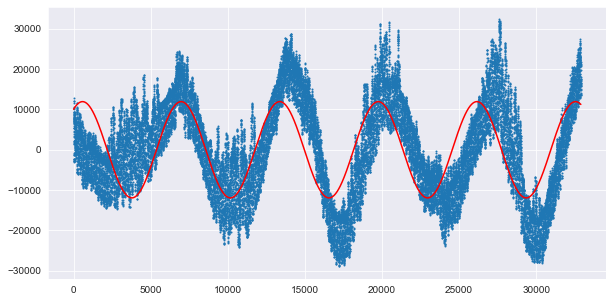

In [26]:
plt.figure(figsize = (10,5))
plt.scatter(date,Xt6,s=1)
plt.plot(date,func(date,c_est, d_est, e_est),"r")

In [53]:
list(energy)

[29309.0,
 28236.0,
 27692.0,
 27596.0,
 27888.0,
 29382.0,
 31373.0,
 33272.0,
 34133.0,
 35232.0,
 35401.0,
 35331.0,
 34582.0,
 33767.0,
 33026.0,
 32620.0,
 33741.0,
 36510.0,
 36783.0,
 35482.0,
 34305.0,
 33277.0,
 32068.0,
 30824.0,
 25013.0,
 23917.0,
 23327.0,
 23286.0,
 23723.0,
 25444.0,
 28235.0,
 30483.0,
 32825.0,
 34090.0,
 34870.0,
 34921.0,
 34480.0,
 34041.0,
 33711.0,
 33567.0,
 35062.0,
 38368.0,
 38925.0,
 38324.0,
 37760.0,
 36344.0,
 34074.0,
 31552.0,
 24873.0,
 23807.0,
 23270.0,
 23182.0,
 23591.0,
 25004.0,
 27692.0,
 30187.0,
 31570.0,
 32641.0,
 33356.0,
 33516.0,
 33184.0,
 32967.0,
 32664.0,
 32507.0,
 33292.0,
 35472.0,
 35260.0,
 34383.0,
 33535.0,
 32112.0,
 29762.0,
 27167.0,
 24956.0,
 23915.0,
 23379.0,
 23376.0,
 23819.0,
 25369.0,
 27828.0,
 30245.0,
 31463.0,
 32527.0,
 32898.0,
 32591.0,
 32150.0,
 31907.0,
 31588.0,
 31692.0,
 33127.0,
 35224.0,
 34985.0,
 34200.0,
 33441.0,
 32023.0,
 29750.0,
 27063.0,
 26485.0,
 25445.0,
 24969.0,
 24913.0,
